# Explore bias towards entropy induced by activation function

After observing the activations in the hidden layers over the course of training, we want to get a better feeling for the effect that the activation function has on the mutual information of these layers with the input. As the feed-forward mapping of the network is deterministic (up to numerical precision), the mutual information of the hidden layer with the input boils down to the entropy of the hidden layer. 

In the following we will create an artificial sample of data and manipulate it such that it resembles stereotypical distributions after applying a `relu` activation function. We will calculate the entropy for these distributions and compare the effect of bias of the activation function on the entropy of the representation against the effect of forming a more compact representation during training.



In [2]:
import numpy as np
from scipy import stats
from matplotlib import pyplot as plt

We uniformly draw 4096 samples from the interval $[0, 100]$. Below we see the distribution of these values in a histogram with 30 bins. In this simulation the histogram counts serve as the "activation pattern" that could appear in a hidden layer of a neural network for uniformly distributed activations. Moreover we calculate the entropy of this hypothetical activation pattern.

Entropy of the uniform distribution: 4.902789356106396


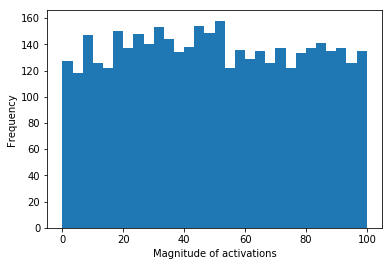

In [3]:
number_of_samples = 4096
uniform = np.random.uniform(0, 100, (number_of_samples,))
uniform_hist, _, _ = plt.hist(uniform, bins=30)
entropy_uniform_dist = stats.entropy(uniform_hist, base=2)
print(f'Entropy of the uniform distribution: {entropy_uniform_dist}')
plt.xlabel("Magnitude of activations")
plt.ylabel("Frequency")
plt.show()

In [4]:
def _set_percentage_to_zero(distribution, percentage):
    """Set a percentage of datapoints in the given distribution to zero"""
    
    distribution = np.copy(distribution) 
    
    number_of_samples = distribution.shape[0]
    proportion = percentage / 100.0
    number_samples_to_zero = int(np.floor(number_of_samples * proportion))
    
    distribution[0:number_samples_to_zero] = 0
    
    return distribution

In order to simulate a pass of the activation pattern through the `relu` nonlinearity, we set 50% of the samples to zero. The resulting distribution is again plotted in a histogram below. moreover, we calculate the entropy of this resulting distribution.

Entropy of the relu like distribution: 3.343388386828526
Compared to the uniform distribution, this is a decrease of entropy by 1.55940096927787 bits.


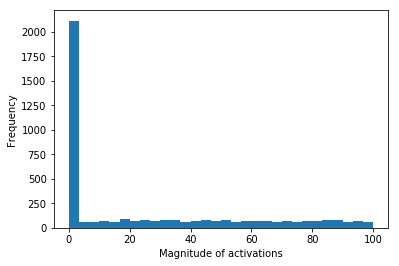

In [7]:
# take a percentage of previously sampled points
relu_like_dist =_set_percentage_to_zero(uniform, 50)

relu_like_hist, _, _ = plt.hist(relu_like_dist, bins=30)
entropy_relu_like_dist = stats.entropy(relu_like_hist, base=2)
print(f'Entropy of the relu like distribution: {entropy_relu_like_dist}')
print(f'Compared to the uniform distribution, this is a decrease of entropy by {entropy_uniform_dist-entropy_relu_like_dist} bits.')
plt.xlabel("Magnitude of activations")
plt.ylabel("Frequency")
plt.show()

We can conclude from this simple experiment, that the `relu` nonlinearity has a strong bias on the mutual information of the representation with the input, as it imposes a lot of structure onto the activations. We hypothesize that `relu` activated hidden layers should therefore carry less information about the input as compared to a `tanh` activated layers. This effect should be immediate from the very beginning of the training. Moreover, within the terminology of the information bottleneck, this boild down to "immediate compression". The exact magnitude of this effect within the experiments we ran has still to be estimated. 

In order to visualize the effect of setting portions of the data samples to zero, we plot the the resulting entropy against the proportion of samples which are set to zero.

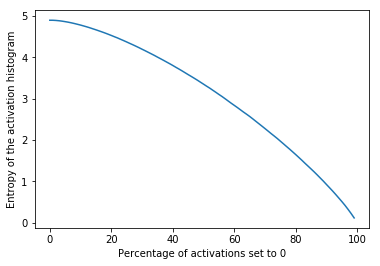

In [5]:
entropies = []
for percentage in np.arange(0, 100, 1):
    relu_like = _set_percentage_to_zero(uniform, percentage)
    relu_like_hist, _ = np.histogram(relu_like, bins=30)
    entropy_relu_like_dist = stats.entropy(relu_like_hist, base=2)
    entropies.append(entropy_relu_like_dist)

plt.figure()
plt.plot(entropies)
plt.xlabel("Percentage of activations set to 0")
plt.ylabel("Entropy of the activation histogram")
plt.show()

In [10]:
def _copy_neighbour(to_transform, iterations):
    """Sets every second value of a vector to the value of the preceding entry"""
    to_transform = np.copy(to_transform)
    to_transform_mass = np.sum(to_transform)

    #shuffle nad replace all nonzero values to simulate more compact representation
    nonzeros = to_transform[to_transform != 0]
    zeros = np.zeros((to_transform.shape[0] - nonzeros.shape[0]))

    for iteration in range(iterations):
        nonzeros[1::2] = nonzeros[0:-1:2]
        np.random.shuffle(nonzeros)

    transformed = np.concatenate((nonzeros, zeros))
    return transformed

By repeatedly setting the value of every second data sample to its preceding neighbour, we "simplify" the representation in the information theoretic sense. After 200 iterations of this transformation, we arrive at a distributions which looks qualitatively similar to those observed after restricting the norm of the weight vector. (See notebook 7.weight_renormalization.ipynb for experiment details)

Entropy of the transformed distribution: 2.55976679824608
Compared to the relu like distribution this is a decrease of 0.783621588582446 bits


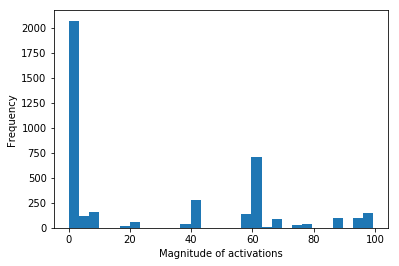

In [24]:
# now impose structure on the 1st till 30th bin
transformed = _copy_neighbour(relu_like_dist, 200) 

transformed_hist, _, _ = plt.hist(transformed, bins=30)
entropy_transformed_dist = stats.entropy(transformed_hist, base=2)
print(f'Entropy of the transformed distribution: {entropy_transformed_dist}')
print(f'Compared to the relu like distribution this is a decrease of {entropy_relu_like_dist-entropy_transformed_dist} bits')
plt.xlabel("Magnitude of activations")
plt.ylabel("Frequency")
plt.show()

We observe that the effect of imposing structure on the non-zero activations reduced the entropy further, but not even matching the amount of redution that was obtained by the relu activation alone. 

We therefore conclude that the bias of the relu activation function towards the mutual information with the input is strong, especially as the its size is not even matched by artifically imposed structure (for example by restricted weight norm) on the nonzero activations. We furthermore hypothesize that the relu compresses in the sense of the information botteneck framework, but does this immediately and not in a distinct phase of the training process. A more qunatitative approach testing this hypothesis is subject of another notebook. 

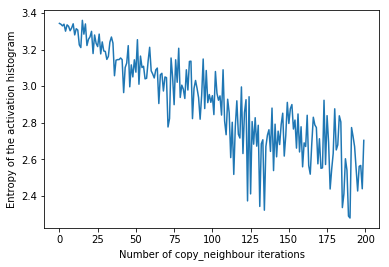

In [15]:
entropies = []
for iterations in np.arange(0, 200, 1):
    dist = _copy_neighbour(relu_like_dist, iterations)
    hist, _ = np.histogram(dist, bins=30)
    entropy_dist = stats.entropy(hist, base=2)
    entropies.append(entropy_dist)

plt.figure()
plt.plot(entropies)
plt.xlabel("Number of copy_neighbour iterations")
plt.ylabel("Entropy of the activation histogram")
plt.show()

The plot above shows the an example of development of entropy over the iterations of "simplifying" the representation. Interesting in this regard is the high variability. The decreasing trand for the value of the entroy with increasing number of iterations is clearly visible.